In [2]:
# Julia code, not Python!

using PyPlot
using PyCall
using DelimitedFiles
using Format
np = pyimport("numpy")
make_axes_locatable = pyimport("mpl_toolkits.axes_grid1").make_axes_locatable

PyObject <function make_axes_locatable at 0x0000024193410400>

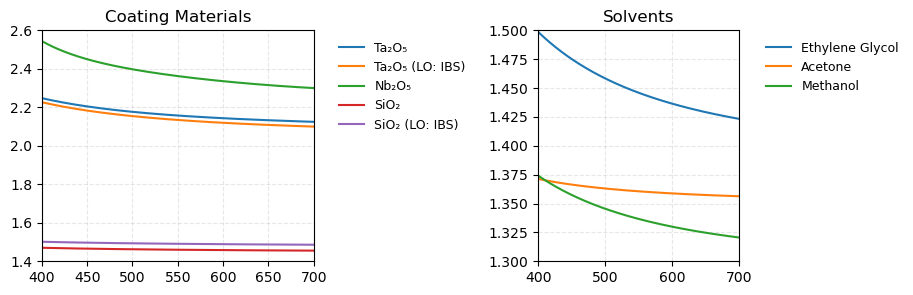

In [3]:
Sellmeier(B, C, λ) = √(1 + sum(Bᵢ*λ^2/(λ^2-Cᵢ) for (Bᵢ, Cᵢ) in zip(B, C)))

# Refractive indices
function n_refr(material, λ::Real)::Float64
    """
    SiO2: https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    Ta2O5: https://refractiveindex.info/?shelf=main&book=Ta2O5&page=Gao
    λ in nm
    """
    λ /= 1000 # nm to μm
    if isa(material, String)
        material = uppercasefirst(material)
    end
    
    if material == "SiO2:IBS" # With IBS, values from Laseroptik
        B = [1.19261271,   0.5415, 0]
        C = [0.0079968567, 61.257, 0]
        return Sellmeier(B, C, λ)
    elseif material == "Ta2O5:IBS" # With IBS, values from Laseroptik
        B = [2.63437,   0.5694, 0.243937]
        C = [0.0355851, 0,      81]
        return Sellmeier(B, C, λ)
    elseif material == "NBK7"
        B = [1.03961212,    0.231792344,  1.01046945]
        C = [0.00600069867, 0.0200179144, 103.560653]
        return Sellmeier(B, C, λ)
    elseif material == "Suprasil" # Heraeus 
        B = [0.473115591, 0.631038719,  0.906404498]
        C = [0.012995717, 0.0041280922, 98.7685322]
        return Sellmeier(B, C, λ)
    elseif material == "SiO2"
        B = [0.6961663, 0.4079426, 0.8974794]
        C = [0.0684043, 0.1162414, 9.8961610]
        return √(1 + sum(B[i]*λ^2/(λ^2-C[i]^2) for i in 1:3)) # Not the Sellmeier formular! --> C[i]²
    elseif material == "Ta2O5" # values empiric from fit (exponential + polynomial) to data
        return 6.70419*exp(-11.1521*λ) + 2.27472 - 0.319763*λ + 0.144455*λ^2
    elseif material == "Nb2O5" # values empiric from fit (exponential + polynomial) to data, only valid between 400...800nm
        return 582.098*exp(-22.1463*λ) + 2.94173+ -1.58087*λ + 0.948068*λ^2
    elseif material in ["EthyleneGlycol", "Ethylenglykol", "EthGly", "EthyGly"]
        return 1.386820 + 17856.021e-6 * λ^(-2)
        # return 1.44
    elseif material in ["Acetone", "Aceton"]
        return 1.34979 + 0.00306λ^-2 + 0.00006λ^-4
    elseif material in ["Methanol"]
        return 1.294611 + 12706.403e-6λ^-2
    elseif material in ["Octadecene"]
        return 1.44        
    elseif material in ["Air", "Vac", "Vacuum"]
        return 1.00
    elseif isa(material, Number) # you can also enter a number like 1.24
        return material
    else
        n = parse(Float64, material)
        if n != nothing
            return n
        else
            ArgumentError("Material not found.")
        end
    end
end

λ = 400:700
plt.figure(figsize=(9, 3))
plt.subplot2grid((1, 10), (0, 0), colspan=4, title="Coating Materials", xlim=extrema(λ), ylim=(1.4, 2.6))
plt.plot(λ, [n_refr("Ta2O5", wlen)     for wlen in λ], label="Ta₂O₅")
plt.plot(λ, [n_refr("Ta2O5:IBS", wlen) for wlen in λ], label="Ta₂O₅ (LO: IBS)")
plt.plot(λ, [n_refr("Nb2O5", wlen)     for wlen in λ], label="Nb₂O₅")
plt.plot(λ, [n_refr("SiO2", wlen)      for wlen in λ], label="SiO₂")
plt.plot(λ, [n_refr("SiO2:IBS", wlen)  for wlen in λ], label="SiO₂ (LO: IBS)")
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.6, 1), frameon=false);

plt.subplot2grid((1, 10), (0, 7), colspan=3, title="Solvents", xlim=extrema(λ), ylim=(1.3, 1.5))
plt.plot(λ, [n_refr("EthGly", wlen)    for wlen in λ], label="Ethylene Glycol")
plt.plot(λ, [n_refr("Acetone", wlen)   for wlen in λ], label="Acetone")
plt.plot(λ, [n_refr("Methanol", wlen)  for wlen in λ], label="Methanol")
plt.xlim(extrema(λ)...)
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.85, 1), frameon=false);
# println(n_refr("Nb2O5", 580.0))
plt.gcf()

In [4]:
function GenerateBraggMirrorStack(λ₀::Real, m_high::Union{Real, String}, m_low::Union{Real, String}; N::Integer, topLayer::Bool)
    """
        create layer stack with individual thickness of λ/4
        returns array of layer thicknesses

        Examples:
        - CRD: N=13, Nb2O5, SiO2
        - LO550: N=19, Ta2O5, SiO2
    """
    n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    n = repeat([n₁, n₂], N)

    # add another high n layer on top
    if topLayer == true
        append!(n, n₁)
    end

    d = λ₀ ./ 4n # Thickness: λ/4
    return d
end

function getCustomMirrorStack(;m_high::Union{Real, String}, m_low::Union{Real, String})
    """
        lengths are given in units of λ/4
        reverse order because Laseroptik company provides data from substrate side

        returns array of layer thicknesses
    """

    #----- Improved pump transmission
    # λ₀ = 693e-9
    # d = reverse(λ₀ * [0.75741,0.68876,0.8664,0.84454,1.51678,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.00441,0.46688,0.95273,0.59731,1.89814,1.01,1.01,1.01,1.01,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805])


    #----- Zero degree 2021
    λ₀ = 577e-9
    # n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    # n = reverse(vcat(repeat([n₁, n₂], 24), n₁))
    d = reverse(λ₀ * [0.93606,0.93021,0.94428188025,0.8793,0.67386,0.21653,0.92916,0.85924,0.88793,0.81784,0.82287,0.82589,0.89287,0.87968,0.93094,0.92011,0.98763,1.37457,1.37032,0.94265,0.96662,0.92173,0.91545,0.88216,0.87477,0.85617,0.91143,0.89408,0.9286,0.92307,1.65457,1.004129603043,0.97952,0.9476,0.96056,0.96055,0.97354,0.94413,0.96186,0.97716,0.9836,1.02031,1.22784,1.23484,1.05889,1.00925,0.99314,2.802,1.062,])
        
    #----- Trying Stuff with Nb2O5
    # d = reverse(550e-9 * vcat(repeat([1.35,], 28), repeat([1.0,], 29)))
    
    n₁, n₂ = n_refr(m_high, λ₀*1e9), n_refr(m_low, λ₀*1e9)
    n = repeat([n₁, n₂], length(d)÷2 + 1)[1:length(d)] # alternating refractive indices. Truncate last element if length(d) is odd
    n = reverse(n)

    d ./= 4n # λ/4 stacks
    return d
end

# See also: Open-Filters Paper DOI: 10.1364/AO.47.00C219
function TransmissionOfDielectricMirror(λ::Real, θ₀::Real, d::Vector{<:Real}; medium::Union{Real, String}, substrate::Union{Real, String}, m_high::Union{Real, String}, m_low::Union{Real, String})
    """
        Transmission of a lossless dielectric mirror with custom layer structure

        The effect of the mirror substrate backside is untrivial as it depends if the reflections have to be treated (in-)coherently
        To my understanding, the shown calculations are for a semi-infinite substrate thickness (see paper)
    """
    θ₀ = deg2rad(θ₀)
    # n₀: Medium(e.g. Ethyl. Glyc.), ns: Substrate, Material-1, Material-2
    n₀, ns, n₁, n₂ = n_refr(medium, λ*1e9), n_refr(substrate, λ*1e9), n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    
    n = repeat([n₁, n₂], length(d)÷2 + 1)[1:length(d)] # alternating refractive indices. Truncate last element if length(d) is odd
    
    if n₀ * sin(θ₀) > ns
        return 0.0, 0.0 # total internal reflection, T = 0
    end

    θ =@. asin(n₀ / n * sin(θ₀)) # propagation angle inside the layers
    θ_out = asin(n₀/ns * sin(θ₀))

    δ =@. 2π/λ * n*d * cos(θ) # phase shift per layer, δ = k*d * cos(θ)
    # pseudo-indices
    η₀_s, ηs_s, η_s = n₀ * cos(θ₀), ns * cos(θ_out), n .* cos.(θ)
    η₀_p, ηs_p, η_p = n₀ / cos(θ₀), ns / cos(θ_out), n ./ cos.(θ) 
    # Transfer-Matrix-Generators for s- and p-pol. 
    M_s, M_p = ((
        [ cos(δᵢ)         1im*sin(δᵢ)/ηᵢ;
          1im*sin(δᵢ)*ηᵢ  cos(δᵢ)          ] for (δᵢ, ηᵢ) in zip(δ, η)
                                           ) for η in (η_s, η_p)        )
    # Calculation for s- and p-polarization separately
    v₁_s, v₂_s = [η₀_s -1; η₀_s 1] * prod(M_s) * [1, ηs_s]
    R_s = abs2(v₁_s/v₂_s)
    #
    v₁_p, v₂_p = [η₀_p -1; η₀_p 1] * prod(M_p) * [1, ηs_p]
    R_p = abs2(v₁_p/v₂_p)
    
    [1 .- R_s, 1 .- R_p]
end

TransmissionOfDielectricMirror (generic function with 1 method)

In [5]:
λ = 450.0 : 1 : 650.0
λ₀ = 550
θ = 0.0 : 1 : 90.0

d = GenerateBraggMirrorStack(λ₀*1e-9, "Nb2O5", "SiO2:IBS"; N=13, topLayer=true)
T_raw = [TransmissionOfDielectricMirror(λ_*1e-9, θ_, d, medium="EthGly", substrate="SiO2", m_high="Nb2O5", m_low="SiO2:IBS") for θ_ in θ, λ_ in λ] 

T_s, T_p = [r[1] for r in T_raw], [r[2] for r in T_raw] # s- and p-polarization
T = (T_s + T_p)/2 # Transmission
size(T_raw), size(T_s)

((91, 201), (91, 201))

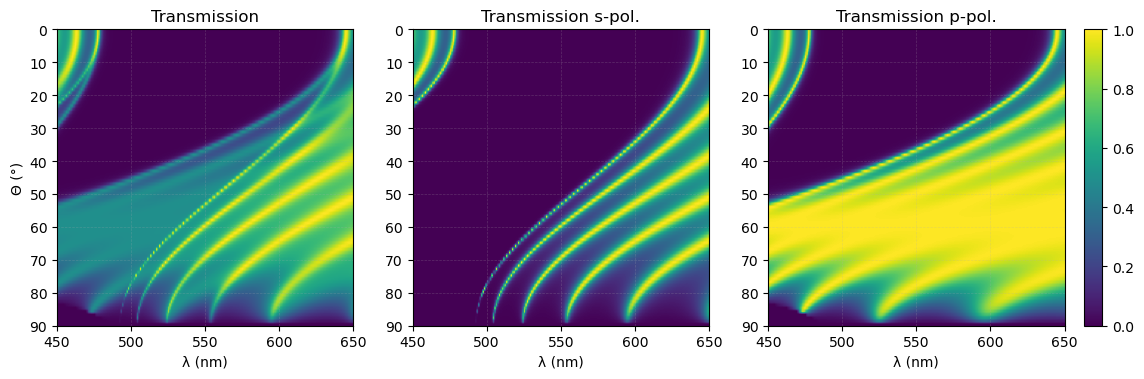

In [7]:
imshow_obj = nothing
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for (ax, Trans, t) in zip(axs, [T, T_s, T_p], ["Transmission", "Transmission s-pol.", "Transmission p-pol."])
    imshow_obj = ax.imshow(Trans,
        extent = (extrema(λ)..., reverse(extrema(θ))...),
        aspect = -(extrema(λ)...)/-(extrema(θ)...),
        vmin = 0, vmax = 1, cmap="viridis"
    )
    ax.set(xlabel="λ (nm)", title=t)
    ax.grid(ls="--", alpha=0.25, lw=0.5)
end
axs[1].set_ylabel("Θ (°)")
# custom colorbar
cax = fig.add_axes([axs[3].get_position().x1+0.015, axs[3].get_position().y0, 0.014, axs[3].get_position().height]) # x, y, width, height
plt.colorbar(imshow_obj, cax=cax);
# plt.savefig("out/CRD550_EthGly.pdf", dpi=300)
plt.gcf()

In [8]:
angle_idx = argmin(abs.(θ .- 42)) # Angle close to...
λ_idx = argmin(abs.(λ .- 532)) # wavelength
scale = "log";

Tₘᵢₙ(θ=42.0°) = 2.62e-08


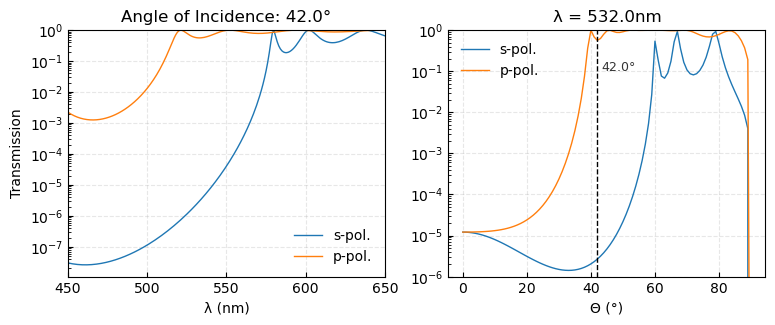

In [10]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121, title=string("Angle of Incidence: $(θ[angle_idx])°"), xlabel="λ (nm)", ylabel="Transmission")
plt.yscale(scale == "log" ? "log" : "linear")
plt.plot(λ, T_s[angle_idx, :], lw=1, label="s-pol.")
plt.plot(λ, T_p[angle_idx, :], lw=1, label="p-pol.")
# plt.plot(wlen_ref, T_ref)
# plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3);
plt.xlim(extrema(λ));
plt.ylim(nothing, 1)
plt.legend(frameon=false);
plt.gca().tick_params(which="both", direction="in")
printfmtln("Tₘᵢₙ(θ={}°) = {:.2e}", θ[angle_idx], minimum(T_s[angle_idx, :]))

plt.subplot(122, title=string("λ = $(λ[λ_idx])nm"), xlabel="Θ (°)")
plt.yscale(ifelse(scale=="log", "log", "linear"))
plt.plot(θ, T_s[:, λ_idx], lw=1, label="s-pol.")
plt.plot(θ, T_p[:, λ_idx], lw=1, label="p-pol.")
plt.grid(ls="--", alpha=0.3)
plt.axvline(θ[angle_idx], lw=1, ls="--", color="k")
plt.text(θ[angle_idx] + 0.012*abs(-(plt.xlim()...)), 0.1, format("{}°", θ[angle_idx]), fontsize=9, alpha=0.8)
plt.ylim(1e-6, 1);
plt.gca().tick_params(which="both", direction="in")
plt.legend(frameon=false);
# plt.tight_layout(); plt.savefig("out/HT532.pdf")
plt.gcf()

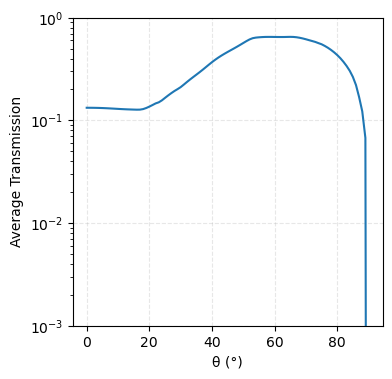

In [11]:
using Statistics
# Losses(λ, Θ) = ∫ T(λ, Θ) * f(λ)  sin(Θ)dΘ dλ
losses = dropdims(mean(T, dims=2), dims=2) # dims=1: vertical, 2: horizontal, reshape because otherwise it's a 1xN Matrix...

plt.figure(figsize=(4, 4))
plt.yscale("log")
plt.plot(θ, losses)
plt.ylim(1e-3, 1)
plt.grid(ls="--", alpha=0.3)
plt.xlabel("θ (°)")
plt.ylabel("Average Transmission")
plt.gcf()

Min: 0.3494972467017764 Max: 0.9386080303061173


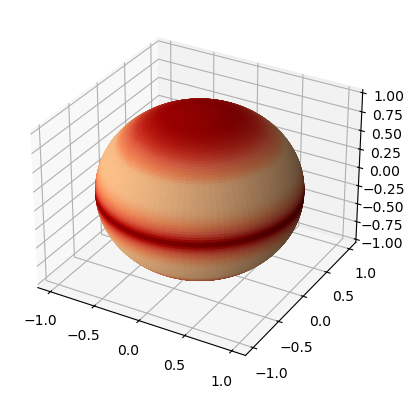

In [13]:
pyimport("mpl_toolkits.mplot3d").Axes3D

theta, phi = np.linspace(0, π, 100), np.linspace(0, 2π, 100)
theta, phi = np.meshgrid(theta, phi)
x, y, z =@. sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)

surface_1 = np.interp(rad2deg.(theta), θ, losses)
surface_2 = np.interp(rad2deg.(π .- theta), θ, losses)

fcolors = 1 .- (surface_1 .+ surface_2)
println("Min: ", minimum(fcolors), " Max: ", maximum(fcolors)); flush(stdout)
fmax, fmin = 1, 0 #maximum(fcolors), minimum(fcolors)
fcolors = (fcolors .- fmin)/(fmax - fmin)

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=matplotlib.cm.OrRd(fcolors))
#ax.set_axis_off()
plt.gcf()